In [1]:
# Local Imports
#from ctrainingdataset import CTrainingDataSet, CreateDataSetFromImageFiles, ReadTrainingSets, ReadLabelDict
import signplot
import p3signs

%load_ext autoreload
%autoreload 1
#%aimport ctrainingdataset
%aimport signplot
%aimport p3signs


In [2]:
%%HTML
<style> code {background-color : orange !important;} </style>
from IPython.core.display import display, HTML
jnk = display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%autoreload 1
#====================== Main() =====================
def Main(gArgs):
    
    #################### Sort-of global object containers
    tfObjs = type("TensorFlowObjectsContainer", (object,), {})
    tfObjs.tph = None  # Assigned in DefineTFPlaceHolders()

    
    #################### READ DATASETS
    dictIDToLabel = p3signs.ReadLabelDict(gArgs.signLabelsCSVFileIn)
    dsTrainRaw, dsValidRaw, dsTestRaw = p3signs.ReadTrainingSets(gArgs.trainingFileIn, gArgs.validationFileIn, gArgs.testingFileIn, dictIDToLabel, truncatedTrainingSetSize = gArgs.truncatedTrainingSetSize)
    signplot.LabeledSampleImages(dsTrainRaw)
    signplot.NumTrainingImagesHistogram(dsTrainRaw, dsValidRaw, dsTestRaw, title="Number Of Training Images")
    

    
    #################### CREATE AUGMENTS
    if (gArgs.doComputeAugments):
        listDSInSegregated, listDSOutAugmentedSegregated, dsOutAugments, dsTrainComplete = p3signs.CreateAugmentedDataSets(dsTrainRaw)
        signplot.PlotListOfDataSets(listDSOutAugmentedSegregated, "augments")
        
        if(gArgs.doSaveTrainCompleteFile):
            print("Saving augment complete file {}".format(gArgs.trainingCompleteFile))
            dsTrainComplete.WritePickleFile(gArgs.trainingCompleteFile)
    else:
        print("Loading augment complete file {}".format(gArgs.trainingCompleteFile))
        dsTrainComplete = p3signs.CTrainingDataSet(name="TrainComplete", pickleFileNameIn = gArgs.trainingCompleteFile, dictIDToLabel = dictIDToLabel)

    signplot.NumTrainingImagesHistogram(dsTrainComplete, dsValidRaw, dsTestRaw, title="Number Of AUGMENTED Training Images")

    
    
    #################### NORM, TRAINING & EVAL
    dsTrainNormComplete, dsValidNorm, dsTestNorm = p3signs.NormalizeDataSets([dsTrainComplete, dsValidRaw, dsTestRaw], gArgs.doConvertGray)
    tfObjs.tph = p3signs.DefineTFPlaceHolders(dsTrainRaw.GetDSNumLabels(), gArgs)
    p3signs.TrainingPipeline(dsTrainNormComplete, dsValidNorm, tfObjs, gArgs)
    p3signs.EvalDataSets([dsTrainNormComplete, dsValidNorm, dsTestNorm], tfObjs, gArgs)
    
    

    #################### EXTRA DATASET
    dsExtraRaw = p3signs.CreateDataSetFromImageFiles(gArgs.finalTestFilesDirIn, dictIDToLabel)
    signplot.LabeledSampleImages(dsExtraRaw)

    dsExtraNorm, = p3signs.NormalizeDataSets([dsExtraRaw], gArgs.doConvertGray)
    p3signs.EvalDataSets([dsExtraNorm], tfObjs, gArgs)
    topk = p3signs.CalcSoftmaxTopK(dsExtraNorm, tfObjs, gArgs)
    signplot.PredictionComparison(dsExtraRaw, dsTrainRaw, topk)




Reading Training sets...
Raw training set size (train, validation, test) =(34799, 4410, 12630)
Image data shape = (32, 32, 3)
Number of classes = 43


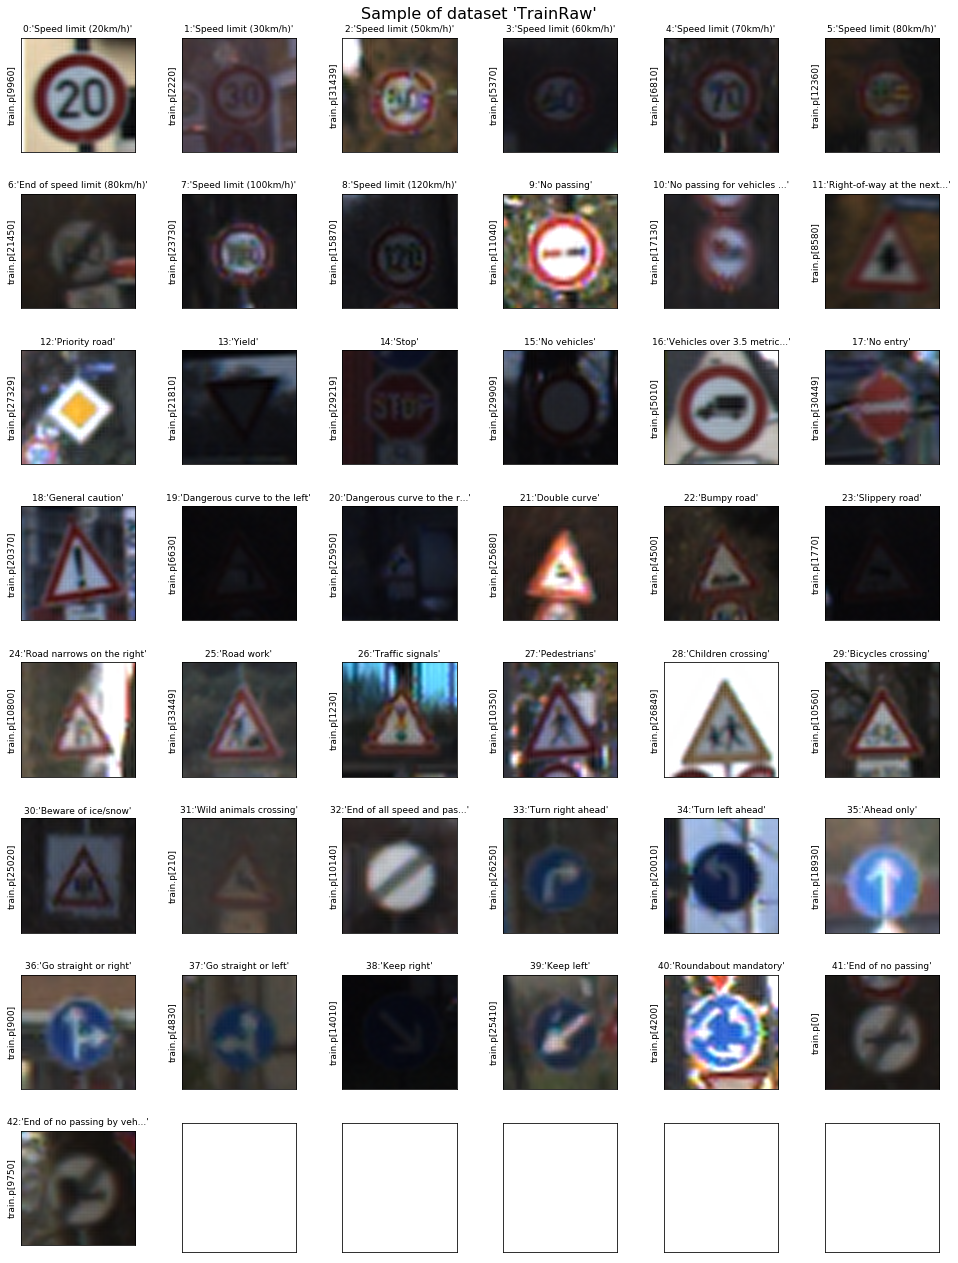

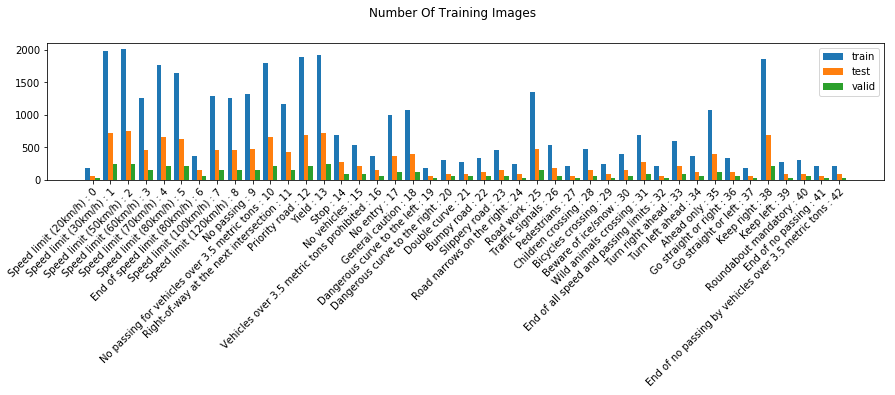

Loading augment complete file ./Assets/training/trainComplete.p


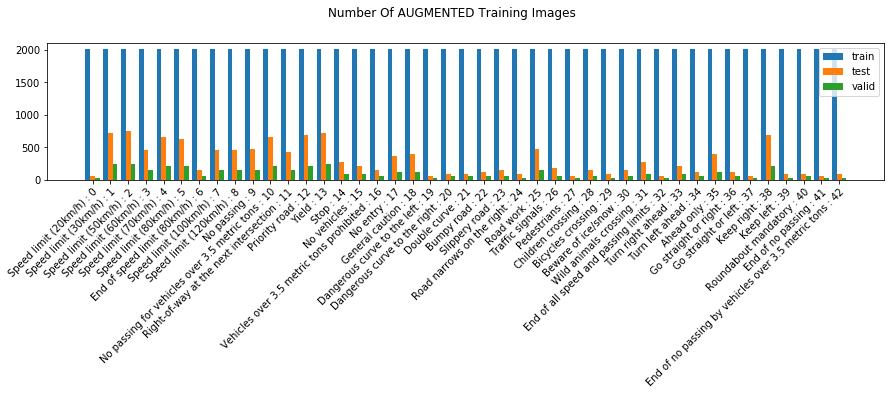


Normalizing... convertGrayScale == True. 29.5 seconds

Training: Epochs=22, TrainRate=0.0009, BatchSize=128 ...
Epoch 01... Validation Accuracy = 0.881
Epoch 02... Validation Accuracy = 0.924
Epoch 03... Validation Accuracy = 0.949
Epoch 04... Validation Accuracy = 0.953
Epoch 05... Validation Accuracy = 0.964
Epoch 06... Validation Accuracy = 0.963
Epoch 07... Validation Accuracy = 0.963
Epoch 08... Validation Accuracy = 0.961
Epoch 09... Validation Accuracy = 0.962
Epoch 10... Validation Accuracy = 0.961
Epoch 11... Validation Accuracy = 0.966
Epoch 12... Validation Accuracy = 0.968
Epoch 13... Validation Accuracy = 0.965
Epoch 14... Validation Accuracy = 0.973
Epoch 15... Validation Accuracy = 0.965
Epoch 16... Validation Accuracy = 0.969
Epoch 17... Validation Accuracy = 0.966
Epoch 18... Validation Accuracy = 0.970
Epoch 19... Validation Accuracy = 0.967
Epoch 20... Validation Accuracy = 0.975
Epoch 21... Validation Accuracy = 0.970
Epoch 22... Validation Accuracy = 0.967
Trainin

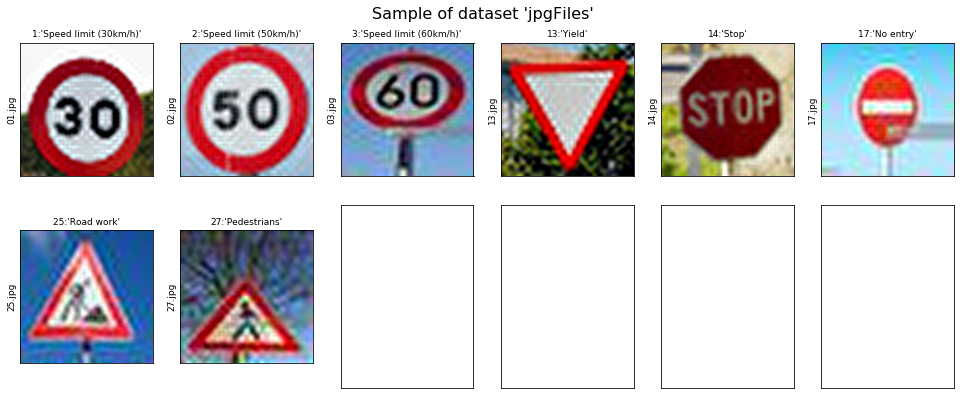


Normalizing... convertGrayScale == True. 0.7 seconds

Eval Model on datasets
Eval DataSet(jpgFilesNorm) Accuracy = 0.500

CalcSoftmaxTopK(jpgFilesNorm)
Image[0]=(    13.jpg) type 13: 'Yield'. 
     PASS! Top 3 Match IDs[13 12 14] => probabilites: [  1.00000000e+00   1.20530131e-11   1.52454687e-12]
Image[1]=(    03.jpg) type 03: 'Speed limit (60km/h)'. 
     FAIL. Top 3 Match IDs[40 17 37] => probabilites: [ 0.97900957  0.01432522  0.00362698]
Image[2]=(    14.jpg) type 14: 'Stop'. 
     PASS! Top 3 Match IDs[14 17 34] => probabilites: [  9.99999881e-01   1.47246283e-07   6.06446490e-11]
Image[3]=(    25.jpg) type 25: 'Road work'. 
     PASS! Top 3 Match IDs[25 30 20] => probabilites: [  9.99998331e-01   1.00913667e-06   3.62275529e-07]
Image[4]=(    17.jpg) type 17: 'No entry'. 
     PASS! Top 3 Match IDs[17 34 32] => probabilites: [  9.99994159e-01   4.82077985e-06   2.52489400e-07]
Image[5]=(    01.jpg) type 01: 'Speed limit (30km/h)'. 
     FAIL. Top 3 Match IDs[5 1 4] => probabil

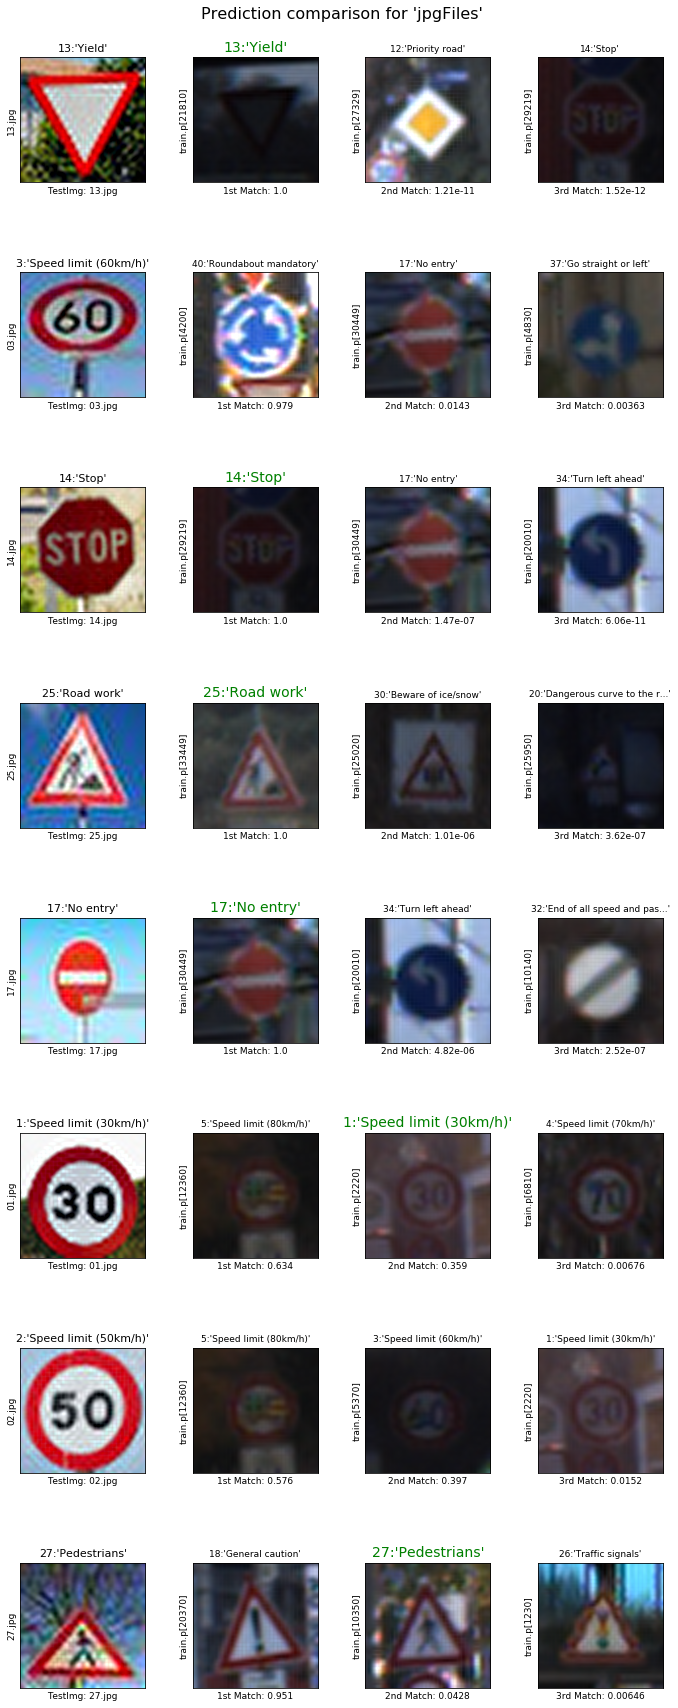

In [6]:
%autoreload 1

#====================== GLOBALS =====================
g_Args = p3signs.GetgArgs()
g_Args.numEpochs = 22
g_Args.batchSize = 128
g_Args.trainRate = 0.0009
g_Args.doConvertGray = True

signplot.g_doShowPlots = True

#====================== Main Invocation =====================
Main(g_Args)